## Introduction
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is collected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables:
- Temperature (T), 
- Ambient Pressure (AP), 
- Relative Humidity (RH), 
- Exhaust Vacuum (V), 
- Electrical energy output (EP) of the plant. 



#### The target of project is predicting the net hourly electrical energy output (EP) of the plant

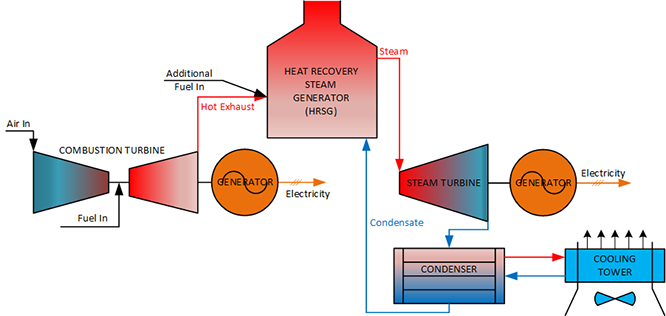
**The photo of combined cycle flow diagram -> https://brdgstn.com/combined-cycle/

## Import libraries

In [1]:
#main libraries
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as  mpatches

#splitting data
from sklearn.model_selection import train_test_split

#preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from feature_engine.imputation import ArbitraryNumberImputer, RandomSampleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


#metrics
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error

#other
import os
 

#Warnings
import warnings
warnings.filterwarnings('ignore')

#openpyxl - Library for reading and writing excel files
import pip
pip.main(["install", "openpyxl"])

### Variables and functions

In [2]:
# Variables for storing metrics
results_mse = pd.DataFrame(columns = ['modelName', 'metric', 'score', 'set'])
results_mae = pd.DataFrame(columns = ['modelName', 'metric', 'score', 'set'])
results_r2score = pd.DataFrame(columns = ['modelName', 'metric', 'score', 'set'])
results_evs = pd.DataFrame(columns = ['modelName', 'metric', 'score', 'set'])

In [3]:
cols = ['AT', 'V', 'AP', 'RH']

In [4]:
# variable to store tails for imputers (list of tails' name)
tails = ['_mean', '_median', '_most_frequent', '_knn', '_random', '_arbitrary'] 

#variable to store colors for imputers plots  (list of color's name)
imp_colors = ['red', 'blue', 'orange', 'green', 'magenta', 'brown']


#variable to store colors for scalers plots  (list of color's name)
sc_colors = ['red', 'blue', 'green', 'magenta']


In [5]:
# Function to check data for null values
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().mean() * 100
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                     'percent_missing': percent_missing
                                    })
    print(missing_value_df)

In [6]:
# Function to add the variables in dataset for check the imputers
def add_imputer_variables(train_df, test_df, column, imputer_name):
    added_column = column + "_" + imputer_name
    train_df[added_column] = train_df[column].copy()
    test_df[added_column] = test_df[column].copy()
    return train_df, test_df

In [7]:
def change_column_name_for_imputering(X_train, X_test, _tail):
    X_train = X_train.add_suffix(_tail)
    X_test = X_test.add_suffix(_tail)
    return X_train, X_test

In [8]:
# Function to convert numpy.array to pandas dataframe
def transformAfterImputation(train_df, test_df, origin_train_df, origin_test_df):
    train_df = pd.DataFrame(train_df, columns = origin_train_df.columns)
    test_df = pd.DataFrame(test_df, columns = origin_test_df.columns)
    return train_df, test_df

In [9]:
#function to reset index of datasets before merging datasets
def reset_index_df(df_list):
    for i in range(len(df_list)):
        df_list[i].reset_index(drop = True, inplace = True)
    return df_list

In [10]:
#function to merge datasets in one
def merge_datasets(df_list):
    merged_df = pd.concat(df_list, axis = 1) 
    return merged_df

In [11]:
#Function to compare imputers for specified variable for test set
def imputer_compare(df, column, tails, colors):
    fig = plt.figure(figsize = (12 ,8))
    ax = fig.add_subplot(111)
    for i in range(len(tails) + 1):
        if i == 0:
            df[column].plot(kind = 'kde', ax = ax)
        else:
            df[f'{column + tails[i - 1]}'].plot(kind = 'kde', ax = ax, color = colors[i - 1])

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc = 'best')
    plt.show()

In [12]:
#Function to plot scalers after using scalers
def scaler_compare_plot(df_list, column_list, colors):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize = (20, 5))
    
    ax1.set_title('Before Scaling')
    ax2.set_title('After Standard Scaling')  
    ax3.set_title('After Min-Max Scaling') 
    ax4.set_title('After Robust Scaling')  
        
    ax_dic = {'ax1' : ax1, 'ax2': ax2, 'ax3': ax3, 'ax4': ax4}
    
    for i in range(len(df_list)):
        for j in range(len(column_list)):
            sns.kdeplot(df_list[i][column_list[j]], ax = list(ax_dic.values())[i], color = colors[j])
    

    plt.legend(labels = column_list)
    plt.show()     

In [13]:
#train ML model, evaluate, save to results dataframe
def training_report_pipe (name, pipe, X_train, X_test):
  
    pipe.fit(X_train, y_train)
    m_results = pd.DataFrame(columns = ['modelName', 'mse', 'mae',  'evs', 'r2'])

    y_pred_train = pipe.predict(X_train)

    r2_score_train =  r2_score(y_train, y_pred_train)
    evs_train = explained_variance_score(y_train, y_pred_train)
    mae_train =  mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)

    y_pred_test = pipe.predict(X_test)
  
    r2_score_test =  r2_score(y_test, y_pred_test)
    evs_test = explained_variance_score(y_test, y_pred_test)
    mae_test =  mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    results_r2score.loc[len(results_r2score.index)] = [name, 'r2_score', round(r2_score_train * 100, 3), 'train']
    results_r2score.loc[len(results_r2score.index)] = [name, 'r2_score', round(r2_score_test * 100, 3), 'test']
    results_evs.loc[len(results_evs.index)] = [name, 'EVS', round(evs_train * 100, 3), 'train']
    results_evs.loc[len(results_evs.index)] = [name, 'EVS', round(evs_test * 100, 3), 'test']
    results_mae.loc[len(results_mae.index)] = [name, 'MAE', round(mae_train, 3), 'train']
    results_mae.loc[len(results_mae.index)] = [name, 'MAE', round(mae_test, 3), 'test']
    results_mse.loc[len(results_mse.index)] = [name, 'MSE', round(mse_train, 3), 'train']
    results_mse.loc[len(results_mse.index)] = [name, 'MSE', round(mse_test, 3), 'test']

    m_results.loc[len(m_results.index)] = [f'{name}_train', round(mse_train, 3), round(mae_train, 3),round(evs_train * 100, 3),round(r2_score_train * 100, 3) ]
    m_results.loc[len(m_results.index)] = [f'{name}_test', round(mse_test, 3), round(mae_test, 3),round(evs_test * 100, 3),round(r2_score_test * 100, 3) ]

    print (m_results)

In [14]:
#function to show final results
def final_results(df):
    #size for plot
    fig, ax = plt.subplots(figsize=(15, 5))
    
    #sort dataset by score and set and reset index
    sorted_df = df.sort_values(by = ['score', 'set'], ascending = True).reset_index()
    
    # create a bar plot by specifying x and y axis and the data to be used.
    ax = sns.barplot(x = "score", y = "modelName", hue = "set", data = sorted_df, orient = 'h')

    # grouped bars will have multiple containers
    for container in ax.containers:
        ax.bar_label(container)

## Data Exploration

In [15]:
# load dataset from excel file
pp_dataset = pd.read_excel("Folds5x2_pp_TP.xlsx")

In [16]:
# Let's see the first 10 rows of dataset
pp_dataset.head(10)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,NaN,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


In [17]:
# show the description of dataset
pp_dataset.describe()

,AT,V,AP,RH,PE
count,9525.000000,9533.000000,9503.000000,9510.000000,9568.000000
mean,19.641594,54.311154,1013.250053,73.291181,454.365009
std,7.454601,12.705674,5.934166,14.593837,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.090000,63.320000,439.750000
50%,20.320000,52.080000,1012.930000,74.955000,451.550000
75%,25.720000,66.540000,1017.250000,84.810000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In dataset 5 variables and the type is float

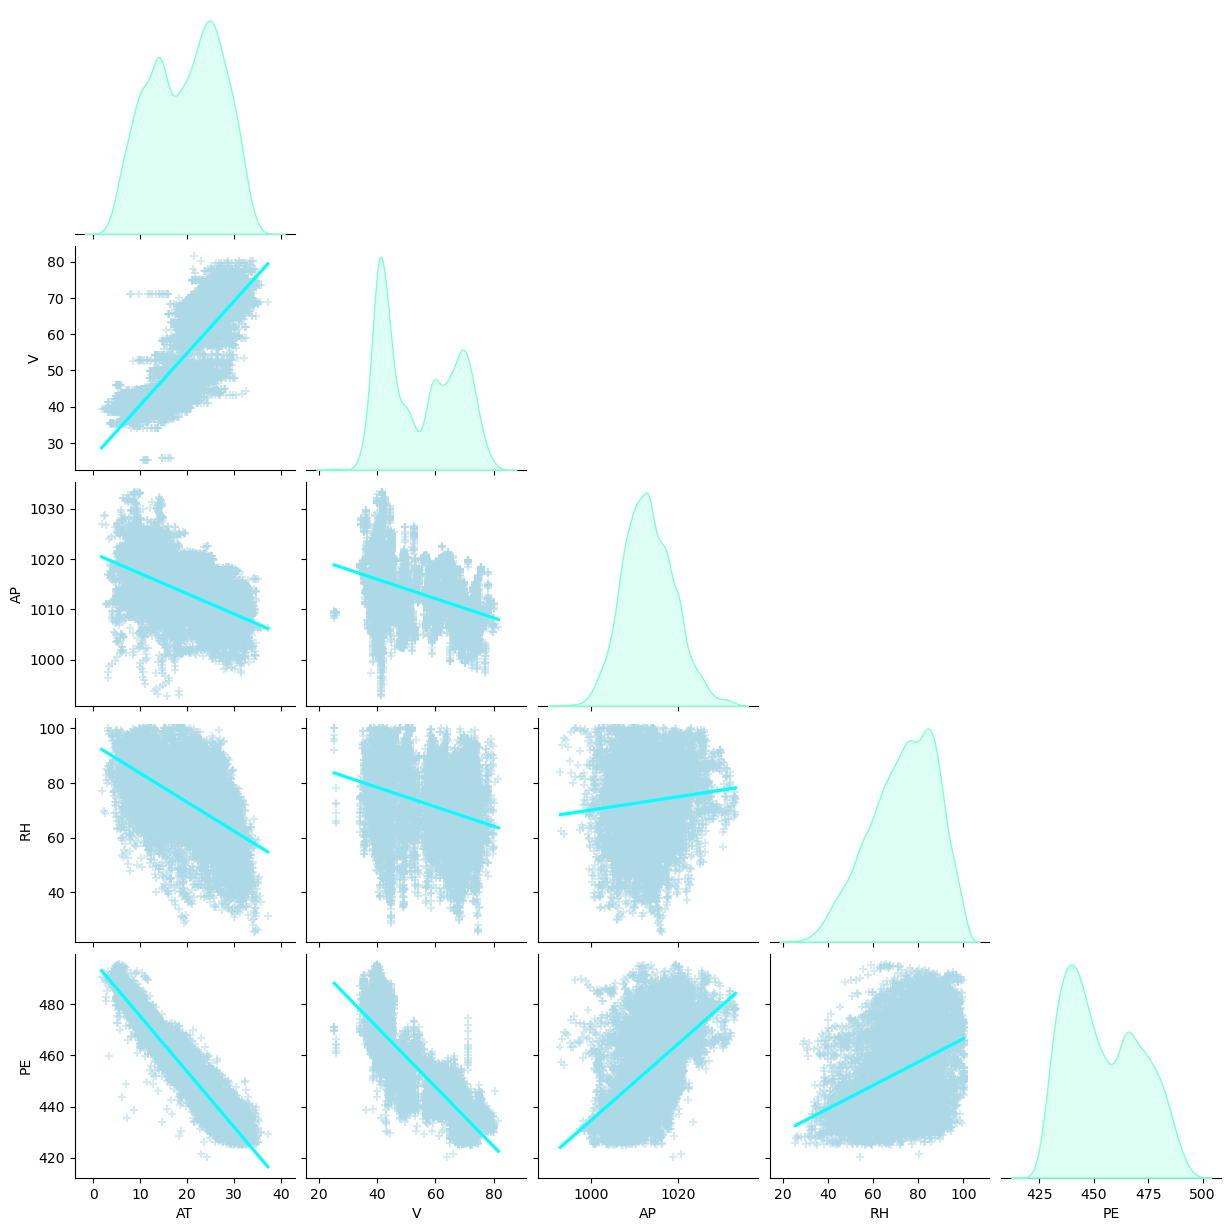

In [18]:
#Plot to visualize relation between variables and distribution of each variable
sns.pairplot(pp_dataset,
             markers = '+',
             kind = 'reg',
             diag_kind = 'kde',
             plot_kws={'scatter_kws': {'alpha': 0.5,
                       'color': 'lightblue'}
                      },
             corner = True,
             diag_kws = {'color': 'aquamarine'})

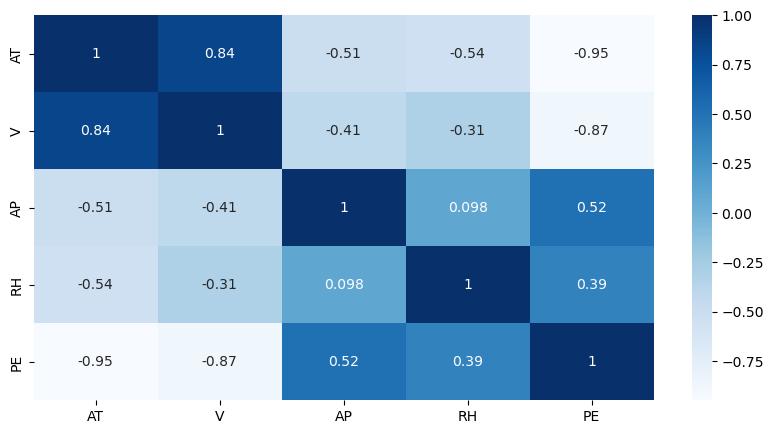

In [19]:
# Compute correlation between the variables
corr = pp_dataset.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, cmap = 'Blues')
plt.show()

Above plot and correlation matrix show the same information about relation of variables and target, but in plot this relation is visualized and in matrix shows extent of relation in digits. Variables 'PE' and 'AT' have high correlation, but 'PE' is our target. And we can't delete 'AT' because it has high prediction power and in the plot the relation is closed to linearity.

## Data Preprocessing : Imputation

In [20]:
#first I need copy the origin dataset (to check in further)
prepocess_df = pp_dataset.copy()

In [21]:
#I need to check the missing values in our dataset bu using function checkDataForNulls
checkDataForNulls(prepocess_df)

   Column  percent_missing
AT     AT         0.449415
V       V         0.365803
AP     AP         0.679348
RH     RH         0.606187
PE     PE         0.000000


As You see, the missing values in our dataset less 1% (PE) - is our target that's why there is no missing values 

In [22]:
#Now I have to split dataset into train and test sets, before I need initialize X - independent variables and y - dependent variable
X = prepocess_df.drop('PE', axis = 1)
y = prepocess_df['PE']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,
    random_state = 42
)
X_train.shape, X_test.shape

((6697, 4), (2871, 4))

As it can be seen from the splitted dataset: train set consists of 6697 rows (70%) and 4 columns and test set consists of 2871(30%) rows and 4 columns

In [23]:
#In order to perform further imputation and scaling train and test datasets were copied

X_train_im = X_train.copy()
X_test_im = X_test.copy()

X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

X_train_grid = X_train.copy()
X_test_grid = X_test.copy()

In [24]:
#Now I check the missing values in train set
checkDataForNulls(X_train)

   Column  percent_missing
AT     AT         0.492758
V       V         0.343437
AP     AP         0.642079
RH     RH         0.597282


In [25]:
#Now I check the missing values in test set
checkDataForNulls(X_test)

   Column  percent_missing
AT     AT         0.348311
V       V         0.417973
AP     AP         0.766284
RH     RH         0.626959


As it can be seen the percentage of missing values per each variable is relatively equal for train and test sets

In [26]:
#Now to show the differences between imputers, train and test datasets will be created for each imputer

#train sets
X_train_mean = X_train.copy()
X_train_median = X_train.copy()
X_train_most_frequent = X_train.copy()
X_train_knn = X_train.copy()
X_train_random = X_train.copy()
X_train_arbitrary = X_train.copy()


#test sets
X_test_mean = X_test.copy()
X_test_median = X_test.copy()
X_test_most_frequent = X_test.copy()
X_test_knn = X_test.copy()
X_test_random = X_test.copy()
X_test_arbitrary = X_test.copy()



In [27]:
X_train.shape, X_test.shape

((6697, 4), (2871, 4))

In [28]:
X_train_mean.shape, X_test_mean.shape

((6697, 4), (2871, 4))

In [29]:
X_train_median.shape, X_test_median.shape

((6697, 4), (2871, 4))

In [30]:
X_train_most_frequent.shape, X_test_most_frequent.shape

((6697, 4), (2871, 4))

In [31]:
X_train_knn.shape, X_test_knn.shape

((6697, 4), (2871, 4))

In [32]:
X_train_random.shape, X_test_random.shape

((6697, 4), (2871, 4))

In [33]:
X_train_arbitrary.shape, X_test_arbitrary.shape

((6697, 4), (2871, 4))

In [34]:
#Will add tails for variables in datasets
X_train_mean, X_test_mean = change_column_name_for_imputering(X_train_mean, X_test_mean, '_mean')
X_train_median, X_test_median = change_column_name_for_imputering(X_train_median, X_test_median, '_median')
X_train_most_frequent, X_test_most_frequent = change_column_name_for_imputering(X_train_most_frequent, X_test_most_frequent, '_most_frequent')
X_train_knn, X_test_knn = change_column_name_for_imputering(X_train_knn, X_test_knn, '_knn')
X_train_random, X_test_random = change_column_name_for_imputering(X_train_random, X_test_random, '_random')
X_train_arbitrary, X_test_arbitrary = change_column_name_for_imputering(X_train_arbitrary, X_test_arbitrary, '_arbitrary')

In [35]:
#After using SimpleImputer and KNNImputer we have to copy datasets, because after imputation these imputers return numpy.array
X_train_mean_copy = X_train_mean.copy()
X_train_median_copy = X_train_median.copy()
X_train_most_frequent_copy = X_train_most_frequent.copy()
X_train_knn_copy = X_train_knn.copy()

X_test_mean_copy = X_test_mean.copy()
X_test_median_copy = X_test_median.copy()
X_test_most_frequent_copy = X_test_most_frequent.copy()
X_test_knn_copy = X_test_knn.copy()

In [36]:
#In this block imputers will be initialized. Imputation with several imputers is performed
mean_im = SimpleImputer(strategy ='mean')
mean_im.fit(X_train_mean)
X_train_mean = mean_im.transform(X_train_mean)
X_test_mean = mean_im.transform(X_test_mean)

median_im = SimpleImputer(strategy ='median')
median_im.fit(X_train_median)
X_train_median = median_im.transform(X_train_median)
X_test_median = median_im.transform(X_test_median)

frequent_im = SimpleImputer(strategy ='most_frequent')
frequent_im.fit(X_train_most_frequent)
X_train_most_frequent = frequent_im.transform(X_train_most_frequent)
X_test_most_frequent = frequent_im.transform(X_test_most_frequent)

knn_im = KNNImputer(n_neighbors = 2, weights = 'uniform')
knn_im.fit(X_train_knn)
X_train_knn = knn_im.transform(X_train_knn)
X_test_knn = knn_im.transform(X_test_knn)

random_im = RandomSampleImputer(variables = ['AT_random', 'V_random', 'AP_random', 'RH_random'])
random_im.fit(X_train_random)
X_train_random = random_im.transform(X_train_random)
X_test_random = random_im.transform(X_test_random)

arb_im =  ArbitraryNumberImputer(arbitrary_number = -1, variables = ['AT_arbitrary', 'V_arbitrary', 'AP_arbitrary', 'RH_arbitrary'])
arb_im.fit(X_train_arbitrary)
X_train_arbitrary = arb_im.transform(X_train_arbitrary)
X_test_arbitrary = arb_im.transform(X_test_arbitrary)


In [37]:
#Now we convert the datasets from numpay.array to pandas dataframe
X_train_mean, X_test_mean = transformAfterImputation(X_train_mean, X_test_mean, X_train_mean_copy, X_test_mean_copy)
X_train_median, X_test_median = transformAfterImputation(X_train_median, X_test_median, X_train_median_copy, X_test_median_copy)
X_train_most_frequent, X_test_most_frequent = transformAfterImputation(X_train_most_frequent, X_test_most_frequent, X_train_most_frequent_copy, X_test_most_frequent_copy)
X_train_knn, X_test_knn = transformAfterImputation(X_train_knn, X_test_knn, X_train_knn_copy, X_test_knn_copy)

In [38]:
#Now I will merge the datasets to one

#create list of datasets
df_list_train = [X_train, X_train_mean, X_train_median, X_train_most_frequent, X_train_knn, X_train_random, X_train_arbitrary]
df_list_test = [X_test, X_test_mean, X_test_median, X_test_most_frequent, X_test_knn, X_test_random, X_test_arbitrary]

#before merging datasets I have to reset indexes
X_train_im = reset_index_df(df_list_train)
X_test_im = reset_index_df(df_list_test)

#merging datasets 
X_train_im = merge_datasets(df_list_train)
X_test_im = merge_datasets(df_list_test)

X_train_im.shape, X_test_im.shape

((6697, 28), (2871, 28))

In [39]:
#check the null values of merged dataset (train set)
X_train_im.isnull().sum()

AT                  33
V                   23
AP                  43
RH                  40
AT_mean              0
V_mean               0
AP_mean              0
RH_mean              0
AT_median            0
V_median             0
AP_median            0
RH_median            0
AT_most_frequent     0
V_most_frequent      0
AP_most_frequent     0
RH_most_frequent     0
AT_knn               0
V_knn                0
AP_knn               0
RH_knn               0
AT_random            0
V_random             0
AP_random            0
RH_random            0
AT_arbitrary         0
V_arbitrary          0
AP_arbitrary         0
RH_arbitrary         0
dtype: int64

In [40]:
#check the null values of merged dataset (test set)
X_test_im.isnull().sum()

AT                  10
V                   12
AP                  22
RH                  18
AT_mean              0
V_mean               0
AP_mean              0
RH_mean              0
AT_median            0
V_median             0
AP_median            0
RH_median            0
AT_most_frequent     0
V_most_frequent      0
AP_most_frequent     0
RH_most_frequent     0
AT_knn               0
V_knn                0
AP_knn               0
RH_knn               0
AT_random            0
V_random             0
AP_random            0
RH_random            0
AT_arbitrary         0
V_arbitrary          0
AP_arbitrary         0
RH_arbitrary         0
dtype: int64

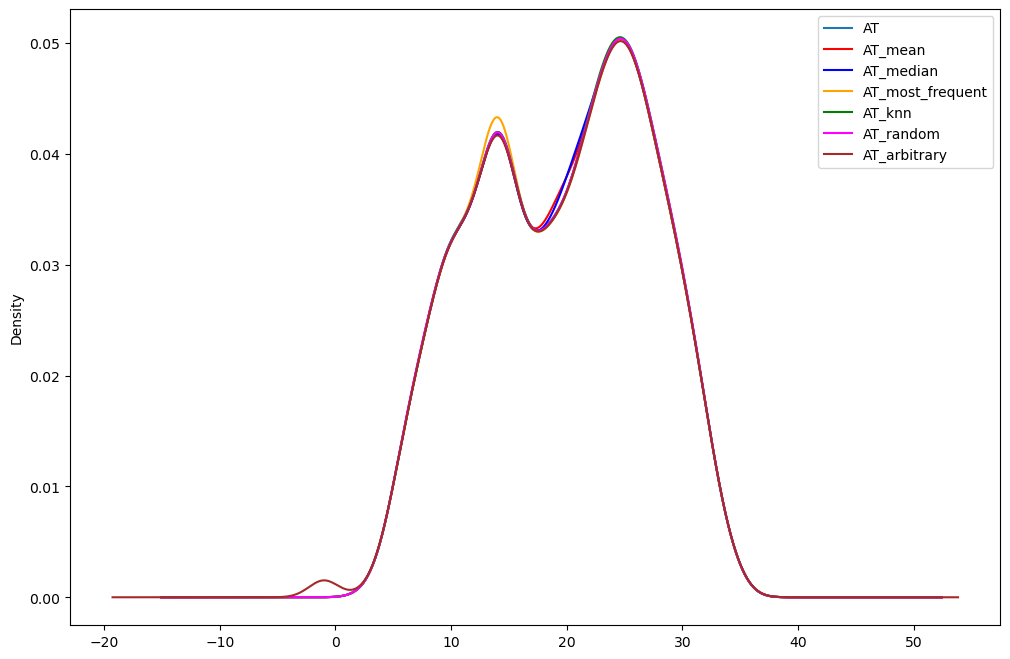

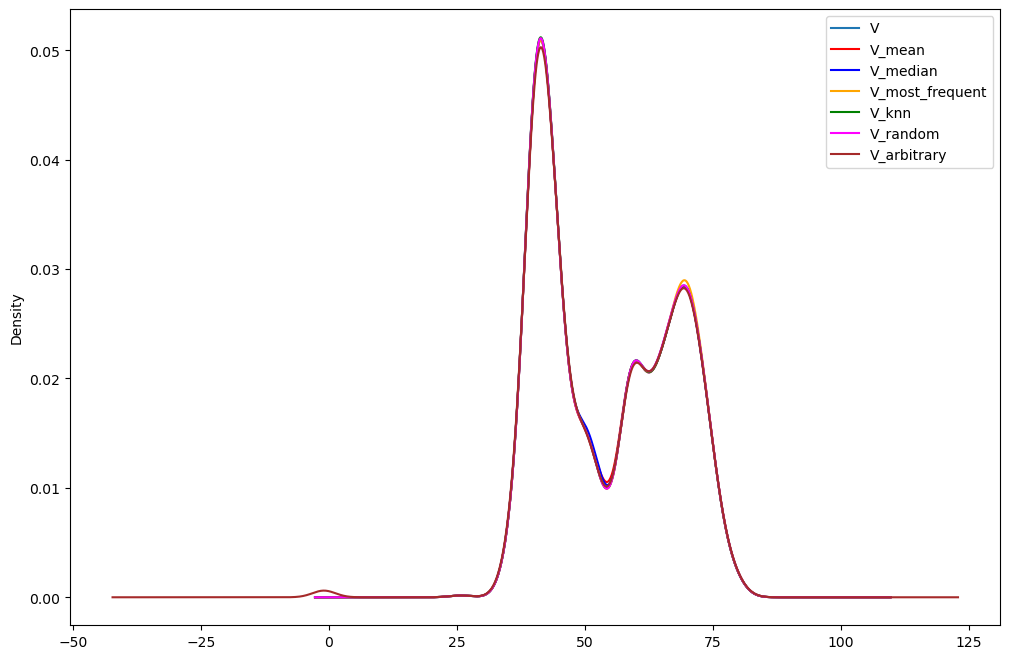

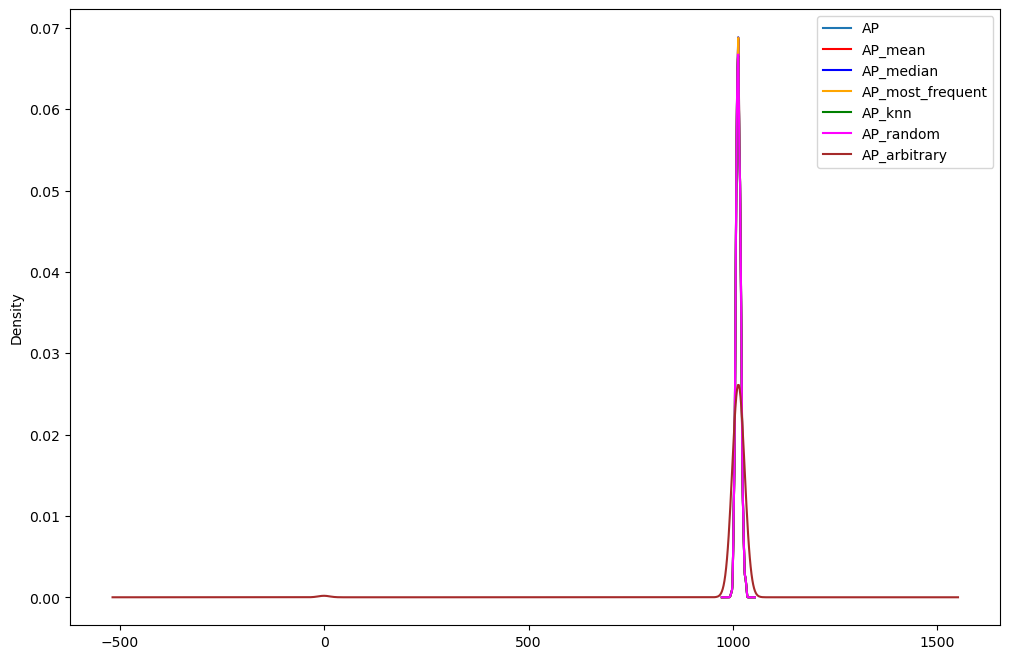

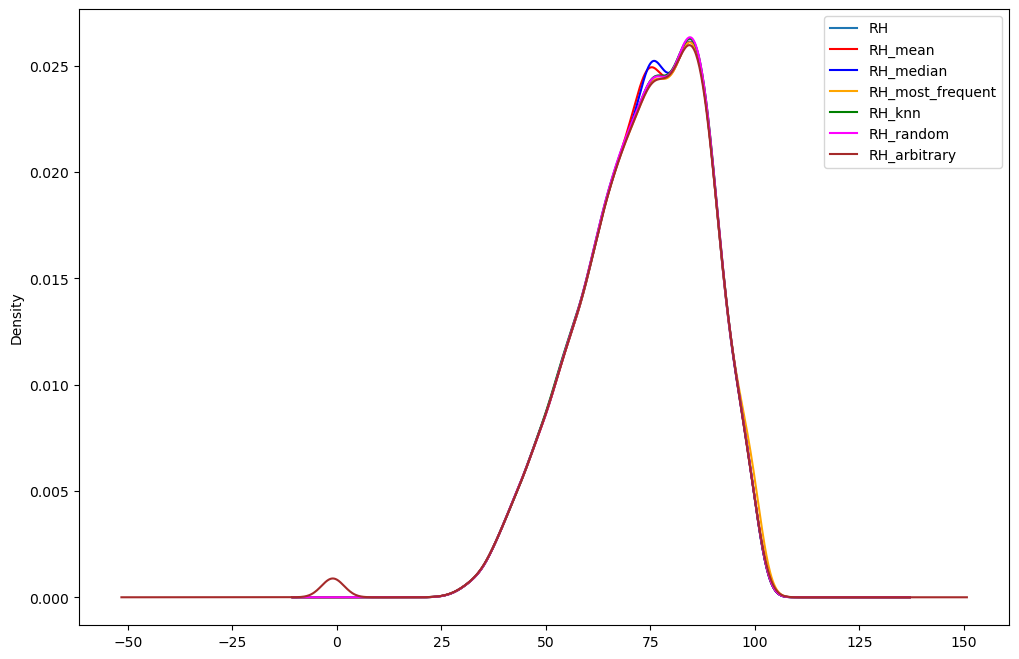

In [41]:
#Let's see the comparasion of imputers (for train set)
for column in cols:
    imputer_compare(X_train_im, column, tails, imp_colors)

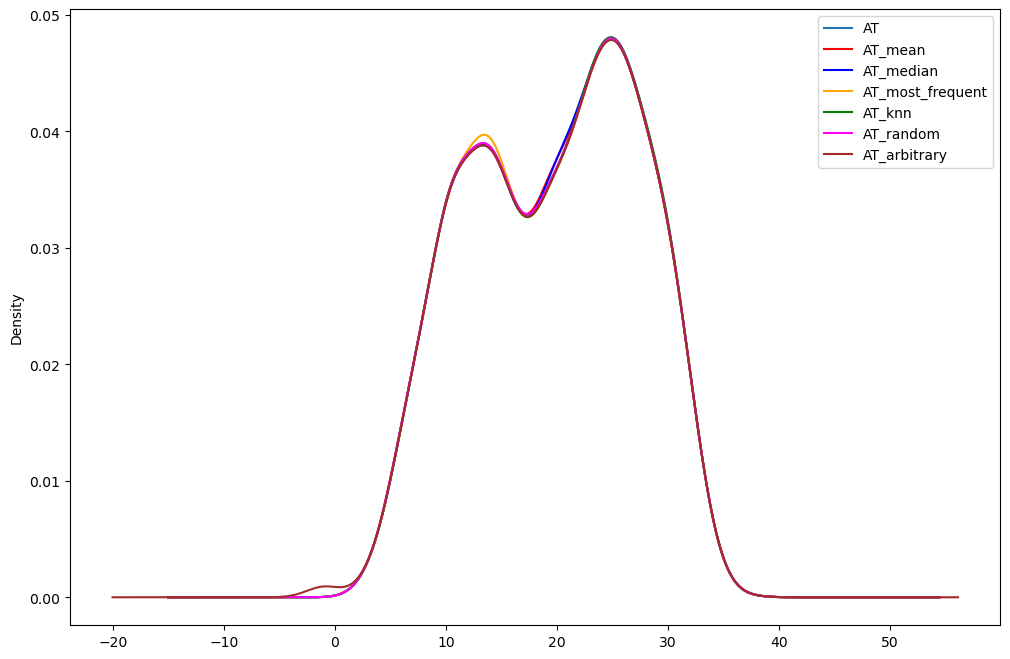

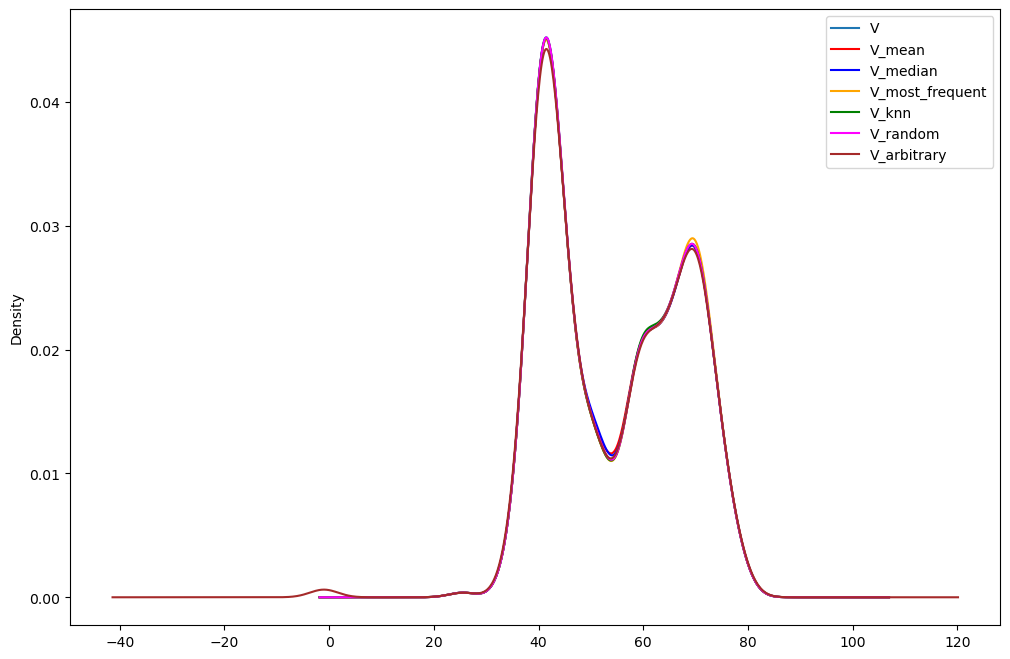

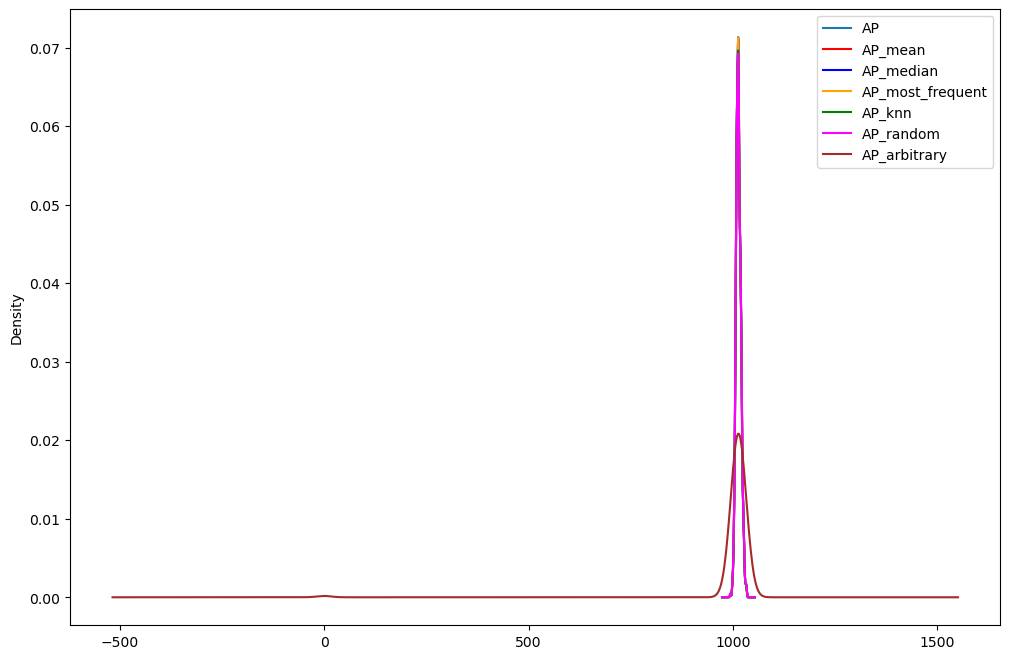

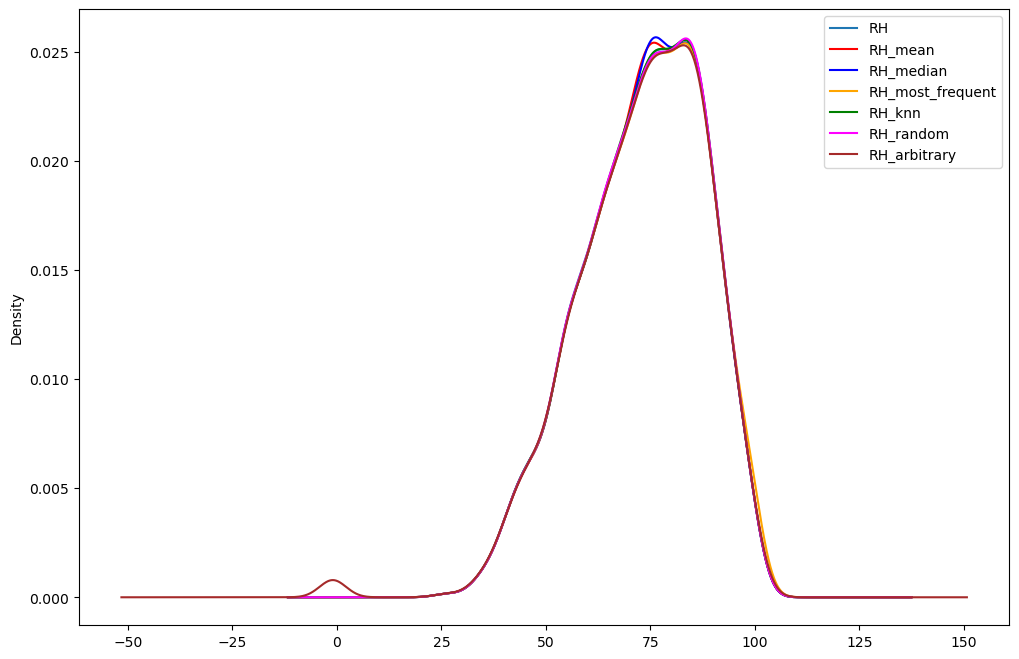

In [42]:
#Let's see the comparasion of imputers (for test set)
for column in cols:
    imputer_compare(X_test_im, column, tails, imp_colors)

Missing values are less 1% and almost all imputers performed well. That's why only one imputer will be applied for all variables

## Data Preprocessing : Scaling

In [43]:
#Check our datasets for scaling
X_train_sc
X_test_sc

,AT,V,AP,RH
2513,19.64,48.06,1014.81,74.96
9411,28.26,69.23,1013.01,42.10
8745,27.98,67.17,1007.32,75.29
9085,28.64,69.23,1013.11,37.13
4950,9.34,38.08,1019.56,67.74
...,...,...,...,...
981,17.90,48.98,1014.17,80.40
4694,29.70,57.35,1005.63,57.35
1407,12.52,41.44,1016.08,68.94
535,9.75,40.81,1026.00,84.44


In [44]:
#To show perform of Scaling the KNNImputer was selected
knn_im = KNNImputer(n_neighbors = 2, weights = 'uniform')
knn_im.fit(X_train_sc)
X_train_sc = knn_im.transform(X_train_sc)
X_test_sc = knn_im.transform(X_test_sc)

In [45]:
#Initializing Standard Scaler 
stand_scaler = StandardScaler()
stand_scaler.fit(X_train_sc)
X_train_standScaled = stand_scaler.transform(X_train_sc)
X_test_standScaled = stand_scaler.transform(X_test_sc)
X_train_standScaled = pd.DataFrame(X_train_standScaled, columns = ['AT','V','AP','RH'])
X_test_standScaled = pd.DataFrame(X_test_standScaled, columns = ['AT','V','AP','RH'])

In [46]:
#Initializing MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_sc)
X_train_mmScaled = mm_scaler.transform(X_train_sc)
X_test_mmScaled = mm_scaler.transform(X_test_sc)
X_train_mmScaled = pd.DataFrame(X_train_mmScaled, columns = ['AT','V','AP','RH'])
X_test_mmScaled = pd.DataFrame(X_test_mmScaled, columns = ['AT','V','AP','RH'])

In [47]:
#Initializing RobustScaler
rob_scaler = RobustScaler()
rob_scaler.fit(X_train_sc)
X_train_robScaled = rob_scaler.transform(X_train_sc)
X_test_robScaled = rob_scaler.transform(X_test_sc)
X_train_robScaled = pd.DataFrame(X_train_robScaled, columns = ['AT','V','AP','RH'])
X_test_robScaled = pd.DataFrame(X_test_robScaled, columns = ['AT','V','AP','RH'])

In [48]:
#Show the train dataset after using Standard Scaler
X_train_standScaled

,AT,V,AP,RH
0,-0.395548,-0.745863,-0.473980,-1.036553
1,0.606135,0.349513,-0.282020,-0.983247
2,-1.421498,-1.121510,3.026752,0.136169
3,-1.351394,-0.979459,3.318059,-0.049034
4,0.154501,0.206672,-0.138893,0.702711
...,...,...,...,...
6692,0.507719,0.602838,-0.484083,-1.670069
6693,-1.077717,-1.079684,1.627470,0.941219
6694,1.100910,1.183672,-0.061436,-1.888758
6695,-0.992783,-1.004712,0.277019,1.097719


In [49]:
#Show the train dataset after using Min Max Scaler
X_train_mmScaled

,AT,V,AP,RH
0,0.440889,0.345552,0.433556,0.431627
1,0.661037,0.592527,0.461767,0.442188
2,0.215407,0.260854,0.948033,0.663959
3,0.230815,0.292883,0.990844,0.627268
4,0.561778,0.560320,0.482801,0.776198
...,...,...,...,...
6692,0.639407,0.649644,0.432071,0.306120
6693,0.290963,0.270285,0.742390,0.823450
6694,0.769778,0.780605,0.494185,0.262794
6695,0.309630,0.287189,0.543925,0.854454


In [50]:
#Show the train dataset after using Robust Scaler
X_train_robScaled

,AT,V,AP,RH
0,-0.302730,-0.289463,-0.312118,-0.782528
1,0.311828,0.270892,-0.172583,-0.746283
2,-0.932175,-0.481631,2.232558,0.014870
3,-0.889165,-0.408962,2.444308,-0.111059
4,0.034739,0.197820,-0.068543,0.400093
...,...,...,...,...
6692,0.251447,0.400484,-0.319461,-1.213290
6693,-0.721257,-0.460234,1.215422,0.562268
6694,0.615385,0.697618,-0.012240,-1.361989
6695,-0.669148,-0.421881,0.233782,0.668680


In [51]:
#I will create list of datasets to compare using scalers (for train and test sets)
train_df_sc =  [X_train, X_train_standScaled, X_train_mmScaled, X_train_robScaled]
test_df_sc =  [X_test, X_test_standScaled, X_test_mmScaled, X_test_robScaled]

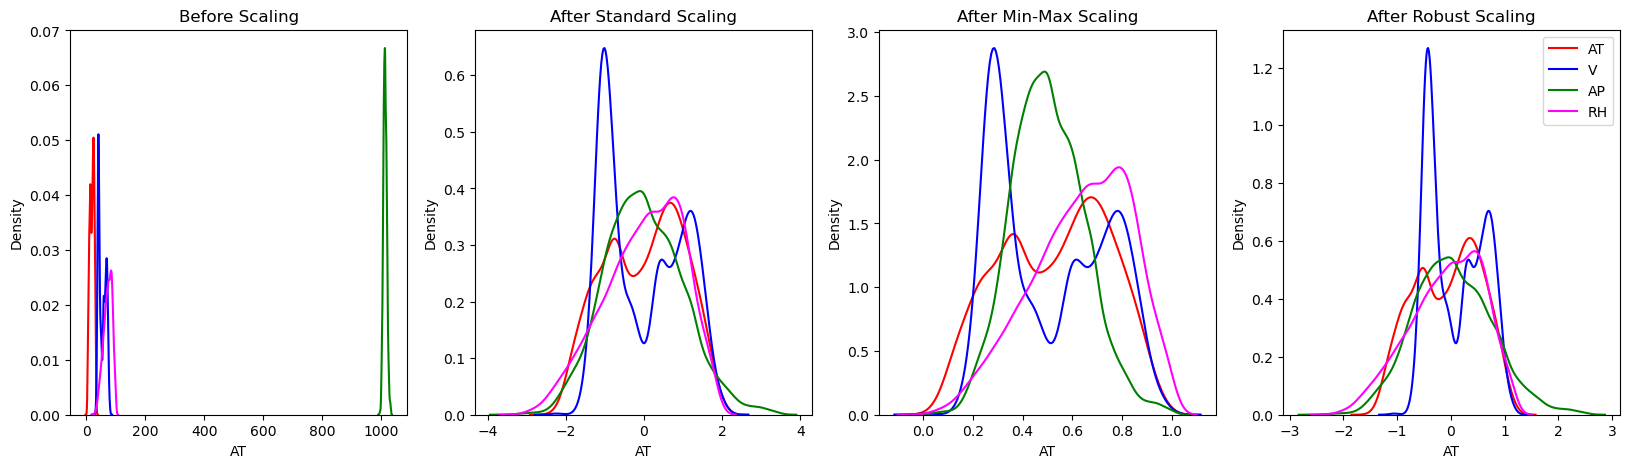

In [52]:
#Let's see the comparasion of scalers for train set
scaler_compare_plot(train_df_sc, cols, sc_colors)

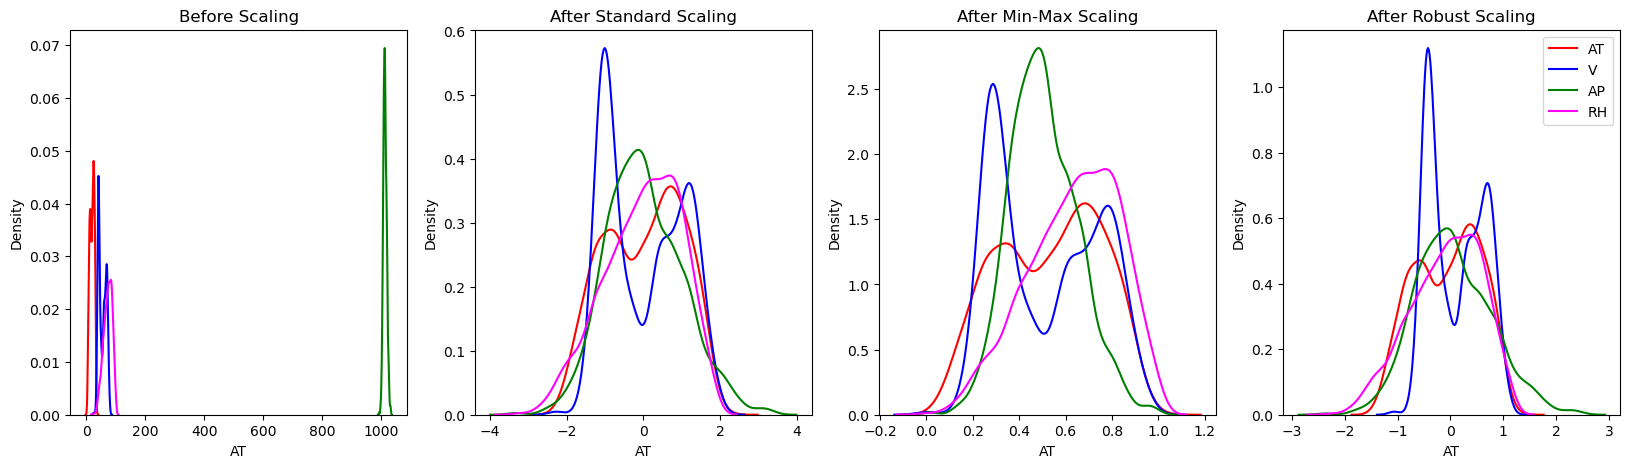

In [53]:
#Let's see the comparasion of scalers for test set
scaler_compare_plot(test_df_sc, cols, sc_colors)

According to the kdeplot the optimal scaler is StandardScaler

# Model Training

## RandomForestRegressor

In [54]:
#Initializing pipeline for Random Forest Regressor
pipe_rfr = Pipeline(steps = 
                    [('imputer', SimpleImputer(strategy = 'mean')), 
                     ('scaler', StandardScaler()), 
                     ('RF', RandomForestRegressor(random_state = 42, criterion = 'absolute_error'))
                    ]
                   )

In [55]:
#parameters for gridsearch
rfr_param_grid = [{
    'imputer':[SimpleImputer(strategy = 'mean'),
               SimpleImputer(strategy = 'median'), 
               SimpleImputer(strategy = 'most_frequent'),
               ArbitraryNumberImputer(arbitrary_number = -1,),
               KNNImputer(n_neighbors = 2),
               RandomSampleImputer()],
    'scaler': [StandardScaler(),
               MinMaxScaler(),
               RobustScaler()], 
    'RF__n_estimators': [100, 150, 200], 
    'RF__max_depth': [2, 3, 4, 5], 
    'RF__criterion' : ['squared_error', 'absolute_error', 'poisson'], 
    'RF__min_samples_leaf': [1.0, 0.05, 0.01]
}]

In [56]:
#Initializing GridSearch
rfr_grid_search = GridSearchCV(
    estimator = pipe_rfr, 
    param_grid = rfr_param_grid, 
    cv = 2, 
    n_jobs = -1, 
    scoring = 'r2'
)

In [57]:
X_train_grid

,AT,V,AP,RH
8759,16.69,44.78,1010.41,58.18
1434,24.12,58.66,1011.55,58.96
7320,9.08,40.02,1031.20,75.34
2579,9.60,41.82,1032.93,72.63
9142,20.77,56.85,1012.40,83.63
...,...,...,...,...
5734,23.39,61.87,1010.35,48.91
5191,11.63,40.55,1022.89,87.12
5390,27.79,69.23,1012.86,45.71
860,12.26,41.50,1014.87,89.41


In [58]:
#fitting
rfr_grid_search.fit(X_train_grid, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('RF',
                                        RandomForestRegressor(criterion='absolute_error',
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid=[{'RF__criterion': ['squared_error', 'absolute_error',
                                            'poisson'],
                          'RF__max_depth': [2, 3, 4, 5],
                          'RF__min_samples_leaf': [1.0, 0.05, 0.01],
                          'RF__n_estimators': [100, 150, 200],
                          'imputer': [SimpleImputer(),
                                      SimpleImputer(strategy='median'),
                                      SimpleImputer(strategy='most_frequent'),
                                      ArbitraryNumberImputer(arbitrary_number=-1),
                                      KNNImputer(n_neighbors=2),
                                      RandomSampleImputer()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler()]}],
             scoring='r2')

In [59]:
#Let's show the results of R2 score for train and test sets
print('{} R2 score train set: {}'.format('RandomForest', rfr_grid_search.score(X_train_grid, y_train)))
print('{} R2 score test set: {}'.format('RandomForest', rfr_grid_search.score(X_test_grid, y_test)))

RandomForest R2 score train set: 0.9415669062149249
RandomForest R2 score test set: 0.9366226359009462


In [60]:
#Let's show the best parameters from GridSearch
rfr_grid_search.best_params_

{'RF__criterion': 'poisson',
 'RF__max_depth': 5,
 'RF__min_samples_leaf': 0.01,
 'RF__n_estimators': 100,
 'imputer': KNNImputer(n_neighbors=2),
 'scaler': StandardScaler()}

In [61]:
#According to the best parameters from GridSearch, I will create pipeline with it
pipe_rfr = Pipeline(steps =
                    [('imputer', KNNImputer(n_neighbors = 2)),
                     ('scaler', StandardScaler()), 
                     ('RF', RandomForestRegressor (
                         random_state = 42, 
                         criterion = 'poisson', 
                         max_depth = 5, 
                         min_samples_leaf = 0.01,
                         n_estimators = 100
                         )
                    )
                    ]
                   )


In [62]:
#Let's see the results of metrics
training_report_pipe('RandomForest', pipe_rfr, X_train_grid, X_test_grid)

            modelName     mse    mae     evs      r2
0  RandomForest_train  16.971  3.185  94.157  94.157
1   RandomForest_test  18.580  3.302  93.662  93.662


## SVR

In [63]:
#Initializing pipeline for SVR
pipe_svr = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'mean')),
                             ('scaler', StandardScaler()), 
                             ('SVR', SVR(kernel = 'rbf'))])

In [64]:
#parameters for gridsearch
svr_param_grid = [{
    'imputer':[SimpleImputer(strategy = 'mean'),
               SimpleImputer(strategy = 'median'), 
               SimpleImputer(strategy = 'most_frequent'),
               ArbitraryNumberImputer(arbitrary_number = -1,),
               KNNImputer(n_neighbors = 2),
               RandomSampleImputer()],
    'scaler': [StandardScaler(),
               MinMaxScaler(),
               RobustScaler()], 
    'SVR__C': [170, 190, 210, 300],
    'SVR__kernel': ['rbf', 'linear', 'poly', 'sigmoid', 'precomputed'],
    'SVR__gamma': ['scale', 'auto']
}]

In [65]:
#Initializing GridSearch
svr_grid_search = GridSearchCV(
    estimator = pipe_svr, 
    param_grid = svr_param_grid, 
    cv = 2,
    n_jobs = -1, scoring = 'r2'
)

In [66]:
#fitting
svr_grid_search.fit(X_train_grid, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('SVR', SVR())]),
             n_jobs=-1,
             param_grid=[{'SVR__C': [170, 190, 210, 300],
                          'SVR__gamma': ['scale', 'auto'],
                          'SVR__kernel': ['rbf', 'linear', 'poly', 'sigmoid',
                                          'precomputed'],
                          'imputer': [SimpleImputer(),
                                      SimpleImputer(strategy='median'),
                                      SimpleImputer(strategy='most_frequent'),
                                      ArbitraryNumberImputer(arbitrary_number=-1),
                                      KNNImputer(n_neighbors=2),
                                      RandomSampleImputer()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler()]}],
             scoring='r2')

In [67]:
#Let's show the results of R2 score for train and test sets
print('{} R2 score train set: {}'.format('SVR', svr_grid_search.score(X_train_grid, y_train)))
print('{} R2 score test set: {}'.format('SVR', svr_grid_search.score(X_test_grid, y_test)))

SVR R2 score train set: 0.9467856229176639
SVR R2 score test set: 0.9442760033066572


In [68]:
#Let's show the best parameters from GridSearch
svr_grid_search.best_params_

{'SVR__C': 190,
 'SVR__gamma': 'scale',
 'SVR__kernel': 'rbf',
 'imputer': KNNImputer(n_neighbors=2),
 'scaler': StandardScaler()}

In [69]:
#According to the best parameters from GridSearch, I will create pipeline with it
pipe_svr = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)),
                             ('scaler', StandardScaler()), 
                             ('SVR', SVR(
                                 kernel = 'rbf',
                                 gamma = 'scale',
                                 C = 190
                                 )
                             )
                            ]
                   )

In [70]:
training_report_pipe('SVR', pipe_svr, X_train_grid, X_test_grid)

   modelName     mse    mae     evs      r2
0  SVR_train  15.455  2.840  94.689  94.679
1   SVR_test  16.336  2.996  94.435  94.428


## XGBoost Regressor

In [71]:
#Initializing pipeline for XGBoost Regressor
pipe_xgb = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'mean')),
                             ('scaler', StandardScaler()), 
                             ('XGB', XGBRegressor(random_state = 42))])

In [72]:
#parameters for gridsearch
xgb_param_grid = [{
    'imputer':[SimpleImputer(strategy = 'mean'),
               SimpleImputer(strategy = 'median'), 
               SimpleImputer(strategy = 'most_frequent'),
               ArbitraryNumberImputer(arbitrary_number = -1,),
               KNNImputer(n_neighbors = 2),
               RandomSampleImputer()],
    'scaler': [StandardScaler(),
               MinMaxScaler(),
               RobustScaler()], 
    'XGB__n_estimators': [100, 150, 200],
    'XGB__max_depth': [6, 8, 10, 12],
    'XGB__learning_rate': [0.01, 0.05, 0.001, 1]
}]

In [73]:
#Initializing GridSearch
xgb_grid_search = GridSearchCV(
    estimator = pipe_xgb, 
    param_grid = xgb_param_grid, 
    cv = 2,
    n_jobs = -1, 
    scoring = 'r2'
)

In [74]:
#fitting
xgb_grid_search.fit(X_train_grid, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_pol...
             param_grid=[{'XGB__learning_rate': [0.01, 0.05, 0.001, 1],
                          'XGB__max_depth': [6, 8, 10, 12],
                          'XGB__n_estimators': [100, 150, 200],
                          'imputer': [SimpleImputer(),
                                      SimpleImputer(strategy='median'),
                                      SimpleImputer(strategy='most_frequent'),
                                      ArbitraryNumberImputer(arbitrary_number=-1),
                                      KNNImputer(n_neighbors=2),
                                      RandomSampleImputer()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler()]}],
             scoring='r2')

In [75]:
#Let's show the results of R2 score for train and test sets
print('{} R2 score train set: {}'.format('XGB', xgb_grid_search.score(X_train_grid, y_train)))
print('{} R2 score test set: {}'.format('XGB', xgb_grid_search.score(X_test_grid, y_test)))

XGB R2 score train set: 0.9871306810339976
XGB R2 score test set: 0.9654197669794704


In [76]:
#Let's show the best parameters from GridSearch
xgb_grid_search.best_params_

{'XGB__learning_rate': 0.05,
 'XGB__max_depth': 10,
 'XGB__n_estimators': 200,
 'imputer': KNNImputer(n_neighbors=2),
 'scaler': StandardScaler()}

In [77]:
#According to the best parameters from GridSearch, I will create pipeline with it
pipe_xgb = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)),
                             ('scaler', StandardScaler()), 
                             ('XGB', XGBRegressor(
                                 random_state = 42,
                                 learning_rate = 0.05,
                                 max_depth = 10,
                                 n_estimators = 200
                                 )
                             )
                            ]
                   )

In [78]:
training_report_pipe('XGBRegressor', pipe_xgb, X_train_grid, X_test_grid)

            modelName     mse    mae     evs      r2
0  XGBRegressor_train   3.738  1.413  98.713  98.713
1   XGBRegressor_test  10.138  2.273  96.542  96.542


## KNeighborsRegressor

In [79]:
#Initializing pipeline for KNeighborsRegressor
pipe_knr = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'mean')),
                             ('scaler', StandardScaler()), 
                             ('KNR', KNeighborsRegressor(p = 1, n_neighbors = 3, algorithm = 'ball_tree', leaf_size = 7, weights = 'distance'))])

In [80]:
#parameters for gridsearch
knr_param_grid = [{
    'imputer':[SimpleImputer(strategy = 'mean'),
               SimpleImputer(strategy = 'median'), 
               SimpleImputer(strategy = 'most_frequent'),
               ArbitraryNumberImputer(arbitrary_number = -1,),
               KNNImputer(n_neighbors = 2),
               RandomSampleImputer()],
    'scaler': [StandardScaler(),
               MinMaxScaler(),
               RobustScaler()], 
    'KNR__weights': ['uniform', 'distance'],
    'KNR__p': [1, 2],
    'KNR__n_neighbors': [3, 5, 7, 9, 11],
    'KNR__metric': ['minkowski', 'manhattan', 'euclidean'],
    'KNR__algorithm': ['ball_tree', 'kd_tree', 'auto', 'brute'],
    'KNR__leaf_size': [3, 4, 5, 7, 10]
}]

In [81]:
#Initializing GridSearch
knr_grid_search = GridSearchCV(
    estimator = pipe_knr,
    param_grid = knr_param_grid, 
    cv = 2,
    n_jobs = -1, 
    scoring = 'r2'
)

In [82]:
#fitting
knr_grid_search.fit(X_train_grid, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('KNR',
                                        KNeighborsRegressor(algorithm='ball_tree',
                                                            leaf_size=7,
                                                            n_neighbors=3, p=1,
                                                            weights='distance'))]),
             n_jobs=-1,
             param_grid=[{'KNR__algorithm': ['ball_tree', 'kd_tree', 'auto',
                                             'brute'],
                          'KNR__leaf_size': [3, 4, 5, 7, 10],
                          'KNR__metric': ['minkowski', 'manhattan',...
                          'KNR__n_neighbors': [3, 5, 7, 9, 11],
                          'KNR__p': [1, 2],
                          'KNR__weights': ['uniform', 'distance'],
                          'imputer': [SimpleImputer(),
                                      SimpleImputer(strategy='median'),
                                      SimpleImputer(strategy='most_frequent'),
                                      ArbitraryNumberImputer(arbitrary_number=-1),
                                      KNNImputer(n_neighbors=2),
                                      RandomSampleImputer()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler()]}],
             scoring='r2')

In [83]:
#Let's show the results of R2 score for train and test sets
print('{} R2 score train set: {}'.format('KNeighborsRegressor', knr_grid_search.score(X_train_grid, y_train)))
print('{} R2 score test set: {}'.format('KNeighborsRegressor', knr_grid_search.score(X_test_grid, y_test)))

KNeighborsRegressor R2 score train set: 1.0
KNeighborsRegressor R2 score test set: 0.955659046511154


In [84]:
#Let's show the best parameters from GridSearch
knr_grid_search.best_params_

{'KNR__algorithm': 'ball_tree',
 'KNR__leaf_size': 3,
 'KNR__metric': 'minkowski',
 'KNR__n_neighbors': 11,
 'KNR__p': 1,
 'KNR__weights': 'distance',
 'imputer': KNNImputer(n_neighbors=2),
 'scaler': MinMaxScaler()}

In [85]:
#According to the best parameters from GridSearch, I will create pipeline with it
pipe_knr = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)),
                             ('scaler', MinMaxScaler()), 
                             ('KNR', KNeighborsRegressor(
                                 weights = 'distance', 
                                 p = 1,                         
                                 n_neighbors = 11,                         
                                 metric = 'minkowski',                        
                                 algorithm = 'ball_tree',                        
                                 leaf_size = 3                       
                                 )
                             )
                            ]
                   )

In [86]:
training_report_pipe ('KNNRegressor', pipe_knr, X_train_grid, X_test_grid)

            modelName     mse    mae      evs       r2
0  KNNRegressor_train   0.000  0.000  100.000  100.000
1   KNNRegressor_test  12.999  2.586   95.566   95.566


## GradientBoostingRegressor

In [87]:
#Initializing pipeline for GradientBoostingRegressor
pipe_gbr = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'mean')),
                             ('scaler', StandardScaler()), 
                             ('GBR', GradientBoostingRegressor())])

In [88]:
#parameters for gridsearch
gbr_param_grid = [{
    'imputer':[SimpleImputer(strategy = 'mean'),
               SimpleImputer(strategy = 'median'), 
               SimpleImputer(strategy = 'most_frequent'),
               ArbitraryNumberImputer(arbitrary_number = -1,),
               KNNImputer(n_neighbors = 2),
               RandomSampleImputer()],
    'scaler': [StandardScaler(),
               MinMaxScaler(),
               RobustScaler()], 
    'GBR__n_estimators': [100, 200, 500, 700],
    'GBR__max_depth': [4, 5, 6],
    'GBR__subsample': [0.5, 0.8, 0.9]
}]

In [89]:
#Initializing GridSearch
gbr_grid_search = GridSearchCV(
    estimator = pipe_gbr, 
    param_grid = gbr_param_grid, 
    cv = 2,
    n_jobs = -1, 
    scoring = 'r2'
)

In [90]:
#fitting
gbr_grid_search.fit(X_train_grid, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('GBR', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'GBR__max_depth': [4, 5, 6],
                          'GBR__n_estimators': [100, 200, 500, 700],
                          'GBR__subsample': [0.5, 0.8, 0.9],
                          'imputer': [SimpleImputer(),
                                      SimpleImputer(strategy='median'),
                                      SimpleImputer(strategy='most_frequent'),
                                      ArbitraryNumberImputer(arbitrary_number=-1),
                                      KNNImputer(n_neighbors=2),
                                      RandomSampleImputer()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler()]}],
             scoring='r2')

In [91]:
#Let's show the results of R2 score for train and test sets
print('{} R2 score train set: {}'.format('GradientBoostingRegressor', gbr_grid_search.score(X_train_grid, y_train)))
print('{} R2 score test set: {}'.format('GradientBoostingRegressor', gbr_grid_search.score(X_test_grid, y_test)))

GradientBoostingRegressor R2 score train set: 0.9942195302076849
GradientBoostingRegressor R2 score test set: 0.9683641079831161


In [92]:
#Let's show the best parameters from GridSearch
gbr_grid_search.best_params_

{'GBR__max_depth': 5,
 'GBR__n_estimators': 700,
 'GBR__subsample': 0.9,
 'imputer': KNNImputer(n_neighbors=2),
 'scaler': RobustScaler()}

In [93]:
#According to the best parameters from GridSearch, I will create pipeline with it
pipe_gbr = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)),
                             ('scaler', RobustScaler()), 
                             ('GBR', GradientBoostingRegressor(
                                 n_estimators = 700,
                                 max_depth = 5,
                                 subsample = 0.9
                                 )
                             )
                            ]
                   )

In [94]:
training_report_pipe('GradientBoostingRegressor', pipe_gbr, X_train_grid, X_test_grid)

                         modelName    mse    mae     evs      r2
0  GradientBoostingRegressor_train  1.721  1.013  99.407  99.407
1   GradientBoostingRegressor_test  9.438  2.172  96.781  96.781


## Metrics

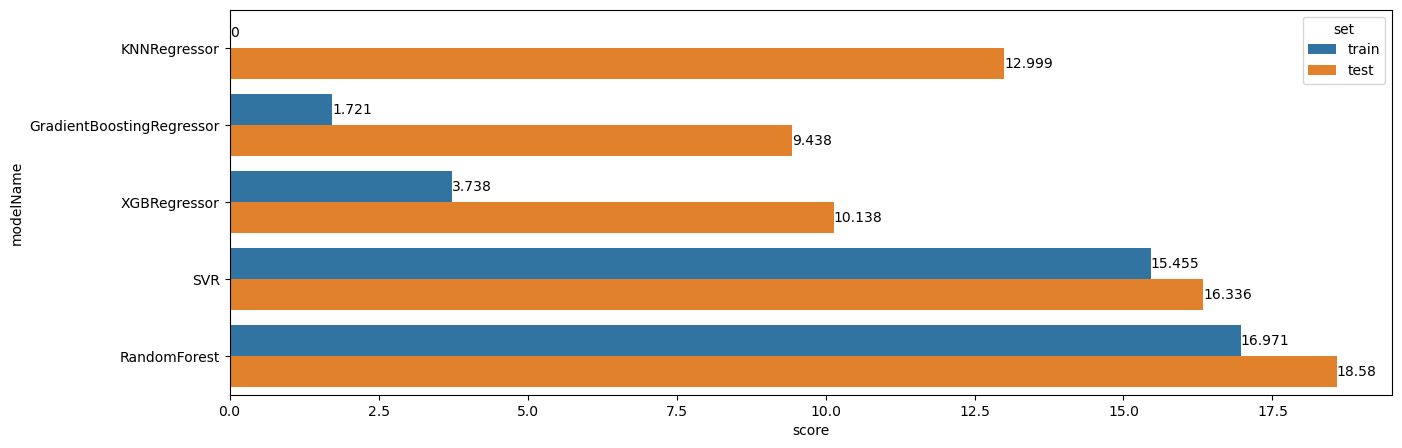

In [95]:
#Let's see the results of MSE for all models
final_results(results_mse)

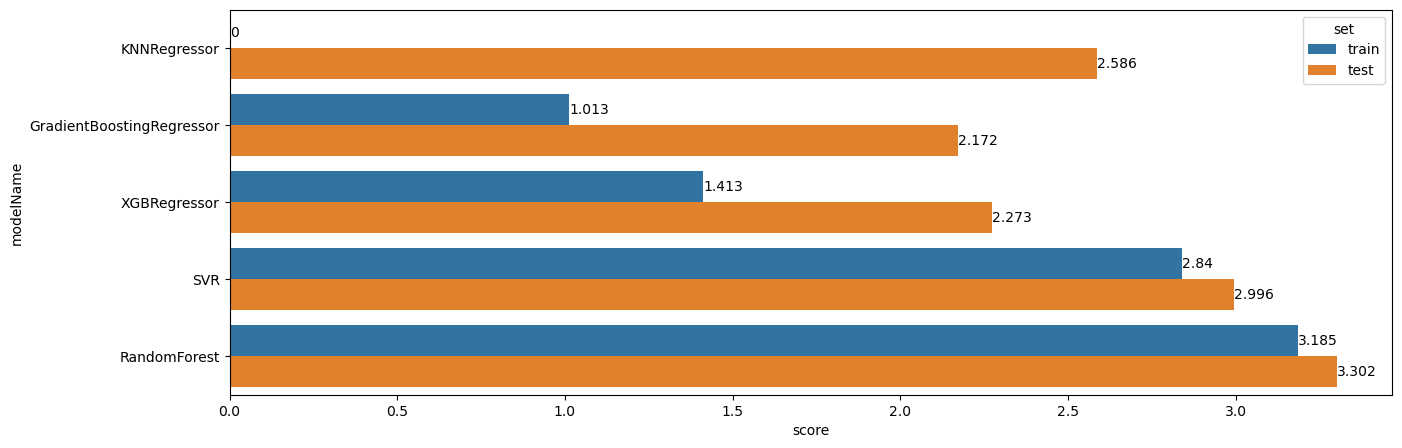

In [96]:
#Let's see the results of MAE for all models
final_results(results_mae)

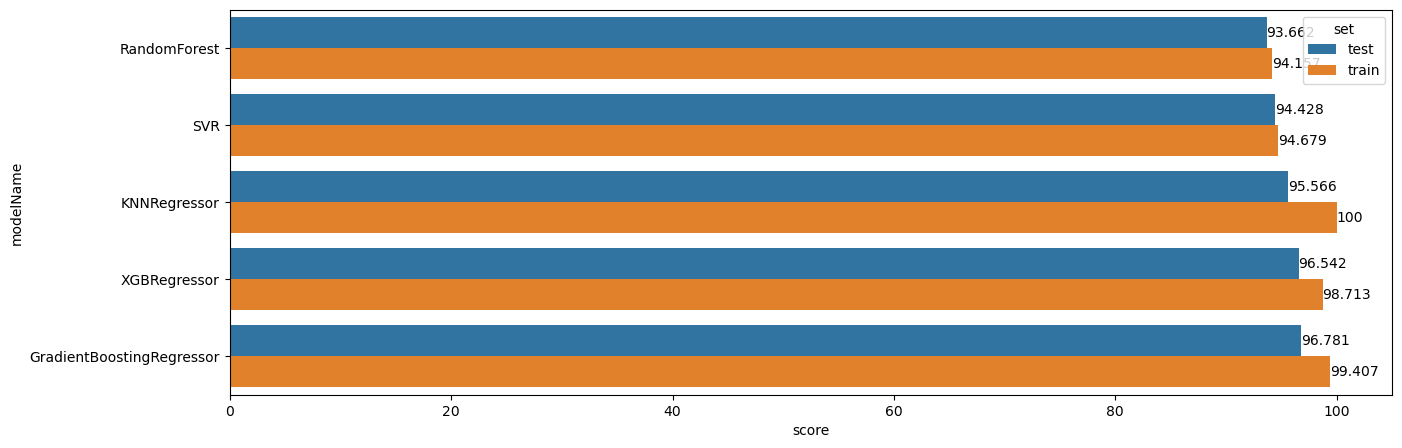

In [97]:
#Let's see the results of R2 score for all models
final_results(results_r2score)

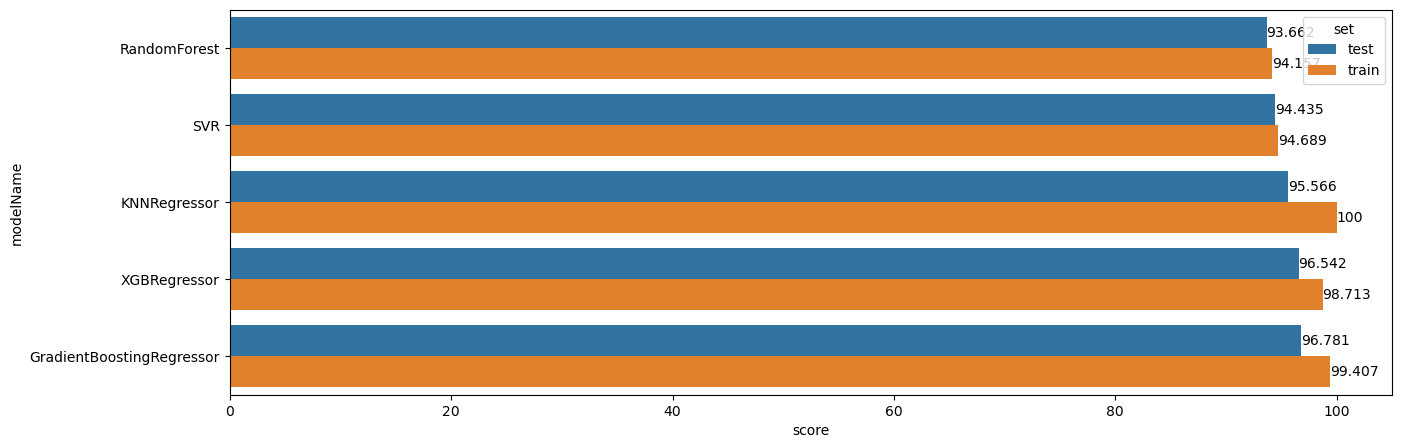

In [98]:
#Let's see the results of EVS for all models
final_results(results_evs)

## Conclusion

>Project goal was to predict the value of Electrical energy output (EP). 
To begin with, an analysis of the dataset was performed to check missing values and the variables distribution. During the dataset analysis, a small number of missing values were found in all independent variables, and I`ve applied imputers such as:
>- SimpleImputer, 
>-KNNImputer, 
>-RandomSampleImputer,
>-ArbitraryNumberImputer. 

>Since the missing values were less than 1 percent, almost all imputers performed well. However, <b><font color = 'green'>KNNImputer </font></b> was used as the basis. 

>Furthermore, since the values of our variables are in different planes, I`ve tested different scalers such as:

>- StandardScaler, 
>-MinMaxScaler, 
>-RobustScaler. 

>Based on the research results, <b><font color = 'green'>StandardScaler</font></b> was found to be the optimal scaler. 

>I then conducted research on various regressors such as: 
>- SVR, 
>-RandomForestRegressor, 
>-XGBRegressor, 
>-KNeighborsRegressor, 
>-GradientBoostingRegressor, 
to predict our target using a pipeline and grid search. 

>The best imputers, scalers, and hyperparameters of each regressor were identified using grid search, and a model was created with these best parameters to obtain values for different metrics.

>After evaluating all four metrics, I concluded that <b><font color = 'green'>SVR</font></b> is the most stable regressor.

>The stable model: 
>- 'imputer': KNNImputer(n_neighbors = 2),
>- 'scaler': StandardScaler()
>- 'C': 190,
>- 'gamma': 'scale',
>- 'kernel': 'rbf',
